In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1. Loading the data

In [23]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]
x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]

label is 9


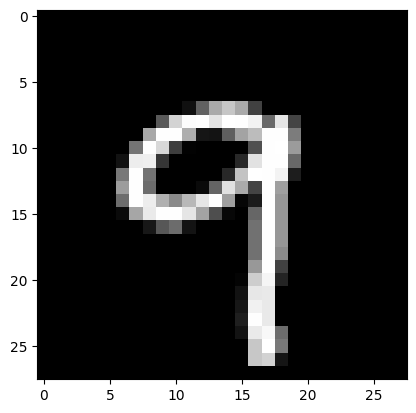

In [3]:
# exploring the data
i = np.random.randint(y_train.size)

print("label is", y_train[i])
plt.imshow(train_data[0][i], cmap='gray')

# 2. Building the model

We use Keras to build a fully-connected neural network.

For more details, see https://keras.io/guides/training_with_built_in_methods/

In [4]:
# source : https://keras.io/guides/training_with_built_in_methods/

def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    return model

model = build_model()

loss = keras.losses.sparse_categorical_crossentropy

model.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ digits (InputLayer)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#question 4

print(f"Numeber of optimization variables: {model.count_params()}")

Numeber of optimization variables: 26506


In [6]:
# untrained model
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
y_pred[0:30]

array([5, 9, 5, 9, 5, 9, 5, 5, 9, 5, 5, 5, 9, 9, 9, 5, 5, 9, 5, 5, 5, 5,
       5, 9, 5, 5, 5, 5, 5, 9])

In [7]:
# what we would like to get
y_train[0:30]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7], dtype=uint8)

# 3. Computing gradients

We are now going to implement the stochastic gradient method using the Keras functionalities.

First, we need to understand how to compute gradients using auto-differentation (also called **backpropagation**).

In [8]:
# Source: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

# Example of gradient computation using automatic differentiation

# selecting a batch
x_train_batch = x_train[:8]
y_train_batch = y_train[:8]

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.

        logits = model(x_train_batch)  # Logits for this minibatch (the logits are the name we give to the Neural Network output)

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

We also define two important helper functions.

In [9]:
## update the weights by adding real_factor * update
def update_weights(model, update, real_factor = 1.):
    new_weights = model.trainable_weights.copy()

    # iterate over all layers
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + real_factor * update[i]

    model.set_weights(new_weights)


# Evaluate model
def mean_loss(model, X, Y):
    logits = model(X)
    return np.mean(loss(Y, logits))

In [10]:
# evaluating the train loss on the whole dataset
# this is a costly operation, use sparsely
mean_loss(model, x_train, y_train)

2.3850904

# 4. Training the model

In [11]:
# Algorithme SGD sans mini-batching
def SGD_without_minibatch(model, x_train, y_train, learning_rate, epochs=1, log_interval=2000):
    # Liste pour stocker les pertes et les itérations associées
    loss_history = []
    iterations = []

    # Vérification des NaN dans les données
    if np.isnan(x_train).any() or np.isnan(y_train).any():
        raise ValueError("Les données d'entrée contiennent des valeurs NaN.")

    iteration_count = 0  # Compteur global d'itérations

    for epoch in range(epochs):
        epoch_loss = 0.0  # Cumul de la perte pour l'époque
        num_samples = len(x_train)

        for i in range(num_samples//2):
            x_sample = x_train[i:i+1]  # Un seul échantillon
            y_sample = y_train[i:i+1]  # Étiquette correspondante

            with tf.GradientTape() as tape:
                logits = model(x_sample)  # Prédictions pour un échantillon
                # Calcul de la perte pour l'échantillon actuel
                loss_value = tf.reduce_mean(
                    tf.keras.losses.sparse_categorical_crossentropy(y_sample, logits)
                )

            # Vérification que la perte est valide
            if tf.math.is_nan(loss_value):
                raise ValueError("La perte est NaN. Vérifiez vos données ou votre modèle.")

            # Calcul des gradients
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Mise à jour des poids du modèle
            update_weights(model, grads, real_factor=-learning_rate)

            # Accumulation de la perte pour l'époque
            epoch_loss += loss_value.numpy()

            # Calcul de la perte toutes les `log_interval` itérations
            if iteration_count % log_interval == 0:
                total_loss = tf.reduce_mean(
                    tf.keras.losses.sparse_categorical_crossentropy(y_train, model(x_train))
                ).numpy()
                loss_history.append(total_loss)
                iterations.append(iteration_count)
                print(f"Iteration {iteration_count}, Loss: {total_loss:.4f}")

            iteration_count += 1

        # Affichage de la perte moyenne à la fin de l'époque
        average_epoch_loss = epoch_loss / num_samples
        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_epoch_loss:.4f}")

    # Retourner l'historique des pertes et les itérations correspondantes
    return iterations, loss_history

In [ ]:
print(len(x_train))

60000


In [12]:
# initialize model
model = build_model()
# Entraînement du model
iterations,loss_history =SGD_without_minibatch(model, x_train, y_train, learning_rate=0.01, epochs=1)

Iteration 0, Loss: 2.3169
Iteration 2000, Loss: 0.6462
Iteration 4000, Loss: 0.4256
Iteration 6000, Loss: 0.3916
Iteration 8000, Loss: 0.4668
Iteration 10000, Loss: 0.3279
Iteration 12000, Loss: 0.3176
Iteration 14000, Loss: 0.3145
Iteration 16000, Loss: 0.2759
Iteration 18000, Loss: 0.2885
Iteration 20000, Loss: 0.2530
Iteration 22000, Loss: 0.2829
Iteration 24000, Loss: 0.2337
Iteration 26000, Loss: 0.2470
Iteration 28000, Loss: 0.2185
Epoch 1/1, Average Loss: 0.1742


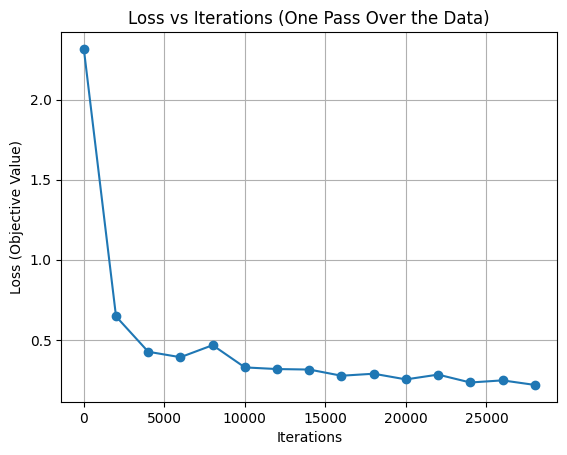

In [13]:
#Q5.2
plt.plot(iterations, loss_history, marker='o')
plt.xlabel("Iterations")
plt.ylabel("Loss (Objective Value)")
plt.title("Loss vs Iterations (One Pass Over the Data)")
plt.grid(True)
plt.show()

Des learning rates plus élevés (0.1 et 0.01) permettent une convergence plus rapide de la perte par rapport à un learning rate plus faible (0.001).

  -Avec un learning rate de 0.1, la perte diminue très rapidement, atteignant une valeur inférieure à 0.2 dès les premières itérations, ce qui indique une convergence efficace.            
  -Le learning rate de 0.01 affiche également une bonne descente de la perte, bien qu'un peu plus lente que 0.10.1, atteignant environ 0.4 après 1500 itérations.        
  -En revanche, le learning rate de 0.001 montre une convergence très lente, avec une perte qui reste élevée (~1.8), illustrant un sous-apprentissage après le même nombre d'itérations.

Cela démontre que le choix du learning rate est crucial : un taux trop petit ralentit l'apprentissage, tandis qu'un taux modéré (comme 0.1 ici) permet d'apprendre rapidement sans instabilité apparente. 🚀

In [15]:
model = build_model()
# Entraînement sur 5 epochs
iterations, loss_history = SGD_without_minibatch(model, x_train, y_train, learning_rate=0.01, epochs=5, log_interval=2000)

Iteration 0, Loss: 2.3335
Iteration 2000, Loss: 0.6430
Iteration 4000, Loss: 0.3888
Iteration 6000, Loss: 0.3639
Iteration 8000, Loss: 0.3940
Iteration 10000, Loss: 0.3020
Iteration 12000, Loss: 0.2899
Iteration 14000, Loss: 0.3014
Iteration 16000, Loss: 0.2651
Iteration 18000, Loss: 0.2624
Iteration 20000, Loss: 0.2519
Iteration 22000, Loss: 0.2941
Iteration 24000, Loss: 0.2089
Iteration 26000, Loss: 0.2313
Iteration 28000, Loss: 0.2600
Epoch 1/5, Average Loss: 0.1618
Iteration 30000, Loss: 0.2363
Iteration 32000, Loss: 0.2090
Iteration 34000, Loss: 0.1940
Iteration 36000, Loss: 0.2084
Iteration 38000, Loss: 0.2930
Iteration 40000, Loss: 0.1830
Iteration 42000, Loss: 0.2031
Iteration 44000, Loss: 0.1835
Iteration 46000, Loss: 0.1629
Iteration 48000, Loss: 0.1921
Iteration 50000, Loss: 0.1980
Iteration 52000, Loss: 0.1740
Iteration 54000, Loss: 0.1773
Iteration 56000, Loss: 0.1765
Iteration 58000, Loss: 0.1660
Epoch 2/5, Average Loss: 0.0872
Iteration 60000, Loss: 0.1907
Iteration 6200

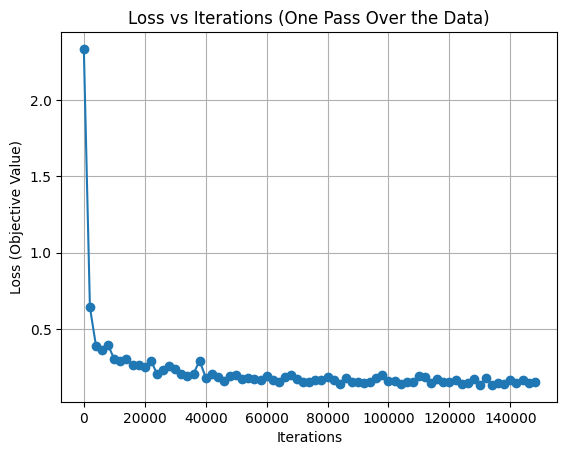

In [16]:
plt.plot(iterations, loss_history, marker='o')
plt.xlabel("Iterations")
plt.ylabel("Loss (Objective Value)")
plt.title("Loss vs Iterations (One Pass Over the Data)")
plt.grid(True)
plt.show()

each epoch allows the model to adjust its weights based on previous errors, gradually improving its performance.

 After multiple epochs, the model has more opportunities to learn complex patterns in the data, leading to a reduction in loss.
 This decrease indicates that the model is converging effectively toward a minimum of the loss function.

In [17]:
#QUESTION 6
# Stochastic gradient algorithm with mini batching

def SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=32, log_interval=2000):
    # Liste pour stocker les pertes et les itérations associées
    loss_history = []
    iterations = []

    # Vérification des NaN dans les données
    if np.isnan(x_train).any() or np.isnan(y_train).any():
        raise ValueError("Les données d'entrée contiennent des valeurs NaN.")

    iteration_count = 0  # Compteur global d'itérations

    for epoch in range(epochs):
        epoch_loss = 0.0  # Cumul de la perte pour l'époque
        num_batches = int(np.ceil(len(x_train) / batch_size))

        for batch_start in range(0, len(x_train), batch_size):
            batch_end = batch_start + batch_size
            x_batch = x_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]

            with tf.GradientTape() as tape:
                logits = model(x_batch)  # Prédictions
                # Calcul de la perte pour le batch actuel
                loss_value = tf.reduce_mean(
                    tf.keras.losses.sparse_categorical_crossentropy(y_batch, logits)
                )

            # Vérification que la perte est valide
            if tf.math.is_nan(loss_value):
                raise ValueError("La perte est NaN. Vérifiez vos données ou votre modèle.")

            # Calcul des gradients
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Mise à jour des poids du modèle
            update_weights(model, grads, real_factor=-learning_rate)

            # Accumulation de la perte pour l'époque
            epoch_loss += loss_value.numpy()

            # Calcul de la perte toutes les `log_interval` itérations
            if iteration_count % log_interval == 0:
                total_loss = tf.reduce_mean(
                    tf.keras.losses.sparse_categorical_crossentropy(y_train, model(x_train))
                ).numpy()
                loss_history.append(total_loss)
                iterations.append(iteration_count)
                print(f"Iteration {iteration_count}, Loss: {total_loss:.4f}")

            iteration_count += 1

        # Affichage de la perte moyenne à la fin de l'époque
        average_epoch_loss = epoch_loss / num_batches
        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_epoch_loss:.4f}")

    # Retourner l'historique des pertes et les itérations correspondantes
    return iterations, loss_history





In [18]:
model = build_model()
# Entraînement sur 5 epochs
iterations, loss_history = SGD(model, x_train, y_train, learning_rate=0.01, epochs=5, log_interval=2000)

Iteration 0, Loss: 2.3894
Epoch 1/5, Average Loss: 0.7190
Iteration 2000, Loss: 0.3550
Epoch 2/5, Average Loss: 0.3222
Iteration 4000, Loss: 0.2918
Epoch 3/5, Average Loss: 0.2704
Iteration 6000, Loss: 0.2565
Epoch 4/5, Average Loss: 0.2377
Iteration 8000, Loss: 0.2182
Epoch 5/5, Average Loss: 0.2142



Minibatching provides a balance between speed and stability by averaging gradients over a small batch, reducing noise compared to pure SGD. It allows for faster convergence with more stable updates

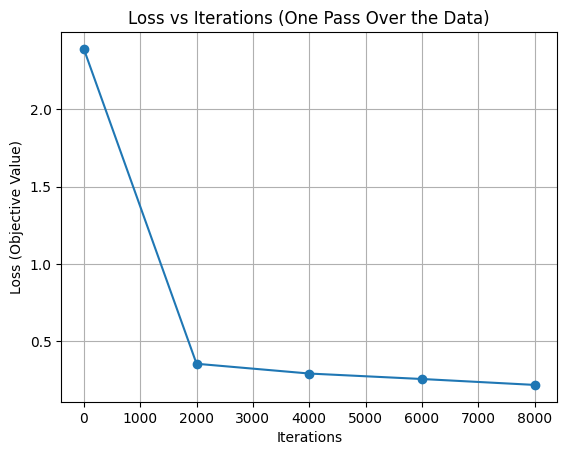

In [19]:
plt.plot(iterations, loss_history, marker='o')
plt.xlabel("Iterations")
plt.ylabel("Loss (Objective Value)")
plt.title("Loss vs Iterations (One Pass Over the Data)")
plt.grid(True)
plt.show()

In [20]:
from sklearn.metrics import accuracy_score

# Function to evaluate model accuracy
def evaluate_accuracy(model, x_data, y_data):
    predictions = model.predict(x_data)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(y_data, predicted_labels)
    return accuracy

In [21]:
# Training with SGD (minibatching)
model_minibatch = build_model()
SGD(model_minibatch, x_train, y_train, learning_rate=0.01, epochs=5, batch_size=32, log_interval=2000)

# Training with SGD (without minibatching)
model_no_minibatch = build_model()
SGD_without_minibatch(model_no_minibatch, x_train, y_train, learning_rate=0.01, epochs=5, log_interval=2000)

Iteration 0, Loss: 2.3240
Epoch 1/5, Average Loss: 0.8425
Iteration 2000, Loss: 0.3659
Epoch 2/5, Average Loss: 0.3310
Iteration 4000, Loss: 0.3036
Epoch 3/5, Average Loss: 0.2805
Iteration 6000, Loss: 0.2669
Epoch 4/5, Average Loss: 0.2509
Iteration 8000, Loss: 0.2323
Epoch 5/5, Average Loss: 0.2289
Iteration 0, Loss: 2.3570
Iteration 2000, Loss: 0.7210
Iteration 4000, Loss: 0.4526
Iteration 6000, Loss: 0.4066
Iteration 8000, Loss: 0.4645
Iteration 10000, Loss: 0.3807
Iteration 12000, Loss: 0.3370
Iteration 14000, Loss: 0.2944
Iteration 16000, Loss: 0.2729
Iteration 18000, Loss: 0.2755
Iteration 20000, Loss: 0.2595
Iteration 22000, Loss: 0.3126
Iteration 24000, Loss: 0.2260
Iteration 26000, Loss: 0.2822
Iteration 28000, Loss: 0.2160
Epoch 1/5, Average Loss: 0.1750
Iteration 30000, Loss: 0.2597
Iteration 32000, Loss: 0.2062
Iteration 34000, Loss: 0.1941
Iteration 36000, Loss: 0.1916
Iteration 38000, Loss: 0.2511
Iteration 40000, Loss: 0.2663
Iteration 42000, Loss: 0.2015
Iteration 4400

([0,
  2000,
  4000,
  6000,
  8000,
  10000,
  12000,
  14000,
  16000,
  18000,
  20000,
  22000,
  24000,
  26000,
  28000,
  30000,
  32000,
  34000,
  36000,
  38000,
  40000,
  42000,
  44000,
  46000,
  48000,
  50000,
  52000,
  54000,
  56000,
  58000,
  60000,
  62000,
  64000,
  66000,
  68000,
  70000,
  72000,
  74000,
  76000,
  78000,
  80000,
  82000,
  84000,
  86000,
  88000,
  90000,
  92000,
  94000,
  96000,
  98000,
  100000,
  102000,
  104000,
  106000,
  108000,
  110000,
  112000,
  114000,
  116000,
  118000,
  120000,
  122000,
  124000,
  126000,
  128000,
  130000,
  132000,
  134000,
  136000,
  138000,
  140000,
  142000,
  144000,
  146000,
  148000],
 [2.3569667,
  0.72096485,
  0.45264897,
  0.4066452,
  0.4645442,
  0.38072613,
  0.33701622,
  0.29444888,
  0.27288112,
  0.27545565,
  0.2594904,
  0.3125501,
  0.22597052,
  0.2821916,
  0.21603025,
  0.2596703,
  0.20624359,
  0.19410312,
  0.19159645,
  0.25114855,
  0.26632896,
  0.20152748,
  0.20

In [25]:
# Evaluate accuracy
train_acc_minibatch = evaluate_accuracy(model_minibatch, x_train, y_train)
test_acc_mb = evaluate_accuracy(model_minibatch, x_test, y_test)

train_acc_no_minibatch = evaluate_accuracy(model_no_minibatch, x_train, y_train)
test_acc_no_mb = evaluate_accuracy(model_no_minibatch, x_test, y_test)


# Display results
print(f"Minibatch SGD - Training Accuracy: {train_acc_minibatch:.4f}, Test Accuracy: {test_acc_mb:.4f}")
print(f"SGD without Minibatch - Training Accuracy: {train_acc_no_minibatch:.4f}, Test Accuracy: {test_acc_no_mb:.4f}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 825us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 799us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
Minibatch SGD - Training Accuracy: 0.9350, Test Accuracy: 0.9351
SGD without Minibatch - Training Accuracy: 0.9560, Test Accuracy: 0.9532


# 📊 Model Accuracy Evaluation: Training vs Test Set

## 1. **Training Accuracy**
Models trained with **SGD using minibatching** often achieve **slightly lower training accuracy** compared to models trained without minibatching. This is because minibatching introduces a **regularizing effect**, preventing the model from overfitting to the training data.  
In contrast, **SGD without minibatching** (batch size = 1) tends to achieve **higher training accuracy** because it aggressively updates the model based on each individual data point, which can lead to **overfitting**.

## 2. **Test Accuracy (Generalization)**
Despite potentially lower training accuracy, models trained with **minibatching** usually show **better generalization performance** on the test set. The smoother gradient updates help the model avoid sharp minima, making it more robust to new, unseen data.  
On the other hand, **SGD without minibatching** might perform worse on the test set due to **overfitting**, as it has adapted too closely to the specific patterns (or even noise) in the training data.

## 3. **Convergence and Stability**
- **Minibatch SGD:** Provides **more stable convergence**, with smoother accuracy improvements over epochs.  
- **Pure SGD (without minibatching):** Can lead to **fluctuations in accuracy** due to the high variance in gradient estimates, making convergence less stable.

## 4. **Impact of Batch Size**
Increasing the batch size generally improves test accuracy up to a certain point. However, if the batch size is **too large**, the model may **converge too quickly to sharp minima**, reducing generalization performance. A **moderate batch size** often provides the best trade-off between **stability** and **generalization**.
